### Машинное обучение
## Домашнее задание №3 - Градиентный бустинг

**Общая информация**

**Срок сдачи:** 14 мая 2024, 23:59   
**Штраф за опоздание:** -2 балла за каждые сутки

Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Считаем производные для функций потерь (1 балл)

Мы будем реализовать градиентный бустинг для 3 функций потерь:

1) MSE  $L(a(x_i), y_i) = (y_i - a(x_i)) ^ 2$

2) Экспоненциальная  $L(a(x_i), y_i) = exp( -a(x_i) y_i), y_i \in \{-1, 1\}$

3) Логистическая  $L(a(x_i), y_i) = \log (1 + exp( -a(x_i) y_i)), y_i \in \{-1, 1\}$

где $a(x_i)$ предсказание бустинга на итом объекте.

Для каждой функции потерь напишите таргет, на который будет настраиваться каждое дерево в бустинге.

MSE:

    s_i = y_i - a_n_1(x_i)

LOG:

    s_i = y_i/(1+exp(y_i*a_n_1(x_i))

EXP:

    s_i = y_i * exp(-y_i*a_n_1(x_i))

##  Реализуем градиентный бустинг (3 балла)

Реализуйте класс градиентного бустинга для классификации. Ваша реализация бустинга должна работать по точности не более чем на 5 процентов хуже чем GradientBoostingClassifier из sklearn.


Детали реализации:

-- должно поддерживаться 3 функции потерь

-- сами базовые алгоритмы(деревья, линейные модели и тп) реализовать не надо, просто возьмите готовые из sklearn

-- в качестве функции потерь для построения одного дерева используйте MSE

-- шаг в бустинге можно не подбирать, можно брать константный

-- можно брать разные модели в качестве инициализации бустинга

-- должны поддерживаться следующие параметры:

а) число итераций
б) размер шага
в) процент случайных фичей при построении одного дерева
д) процент случайных объектов при построении одного дерева
е) параметры базового алгоритма (передавайте через **kwargs)

In [127]:
import numpy as np

from sklearn.datasets import load_wine
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.base import clone

In [128]:
from sklearn.preprocessing import OneHotEncoder

class MyGradientBoostingClassifier:
    def __init__(self, loss="mse", learning_rate=0.1, n_estimators=100, colsample=1.0, subsample=1.0, random_state=0, *args, **kwargs):
        self.loss = loss
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.colsample = colsample
        self.subsample = subsample
        self.base_model_params = kwargs if kwargs else args
        self.random_state = random_state
        self.trees = []
        self.encoder = OneHotEncoder()
        self.fitted = False
        self.init_model = None

    def _softmax(self, z):
        """Функция для многоклассовой классификации"""
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def fit(self, X, y, base_model=DecisionTreeRegressor, init_model=None):

        if self.fitted:
          # условие, чтобы при повторном фите, бустинг снова не учился
          return 0
        self.fitted = True

        # кодирование меток классов для многоклассовой классификации
        if self.loss in ['log_loss', 'exp_loss']:
          y_encoded = self.encoder.fit_transform(y.reshape(-1, 1)).toarray()
        else:
          y_encoded = y[:, np.newaxis]

        n_samples, n_features = X.shape
        n_classes = y_encoded.shape[1]

        if init_model is not None:
          self.init_model = clone(init_model)
          self.init_model.fit(X, y)
          # делаем predict_proba, если их не возвращает сразу обычным предиктом
          y_pred = self.init_model.predict_proba(X)[:, 1] if hasattr(self.init_model, "predict_proba") else self.init_model.predict(X)
        else:
          y_pred = np.zeros((n_samples, n_classes))

        # меняем размерность
        y_pred = y_pred.reshape(-1, 1) if y_pred.ndim == 1 else y_pred

        for _ in range(self.n_estimators):
            trees = []
            for k in range(n_classes):
              # вычисление остатков в зависимости от функции потерь
              if self.loss == 'mse':
                residuals = y_encoded[:, k] - y_pred[:, k]
              elif self.loss == 'exp_loss':
                p = self._softmax(y_pred)
                residuals = y_encoded[:, k] - p[:, k]
              elif self.loss == 'log_loss':
                p = self._softmax(y_pred)
                eps = 1e-10  # Значение epsilon для избежания деления на ноль
                residuals = (y_encoded[:, k] - p[:, k]) / (p[:, k] * (1 - p[:, k]) + eps)

              tree = base_model(**self.base_model_params, random_state=self.random_state)

              # подвыборка объектов
              if 0 < self.subsample < 1.0:
                sample_idx = np.random.choice(n_samples, int(self.subsample * n_samples), replace=False)
              else:
                sample_idx = np.arange(n_samples)

              # подвыборка признаков
              if 0 < self.colsample < 1.0:
                feature_idx = np.random.choice(n_features, int(self.colsample * n_features), replace=False)
              else:
                feature_idx = np.arange(n_features)

              # обучаем на x и на остатках
              tree.fit(X[sample_idx][:, feature_idx], residuals[sample_idx])
              leaf_predictions = tree.predict(X[:, feature_idx])
              y_pred[:, k] += self.learning_rate * leaf_predictions
              trees.append((tree, feature_idx))

            self.trees.append(trees)

    def predict(self, X):
        n_samples = X.shape[0]
        n_classes = len(self.trees[0])

        # если у нас есть init_model, то предсказаываем сначала на нем
        if self.init_model:
          y_pred = self.init_model.predict_proba(X)[:, 1] if hasattr(self.init_model, "predict_proba") else self.init_model.predict(X)
        else:
          y_pred = np.zeros((n_samples, n_classes))

        # меняем размерность
        y_pred = y_pred.reshape(-1, 1) if y_pred.ndim == 1 else y_pred

        for t_idx, trees in enumerate(self.trees):
            for k, (tree, feature_idx) in enumerate(trees):
              y_pred[:, k] += self.learning_rate * tree.predict(X[:, feature_idx])

        if self.loss in ['log_loss', 'exp_loss']:
            probabilities = self._softmax(y_pred)
            return np.argmax(probabilities, axis=1)
        else:
            return np.round(y_pred[:, 0]).astype(int)


In [129]:
my_clf = MyGradientBoostingClassifier(max_depth=2, loss="log_loss")
clf = GradientBoostingClassifier()

In [130]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target, random_state=0)

In [131]:
my_clf.fit(X_train, y_train)
clf.fit(X_train, y_train)
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

1.0
1.0


## Подбираем параметры (2 балла)

Давайте попробуем применить Ваш бустинг для предсказаний цены домов в Калифорнии. Чтобы можно было попробовтаь разные функции потерь, переведем по порогу таргет в 2 класса: дорогие и дешевые дома.

В задании нужно

1) Построить график точности в зависимости от числа итераций на валидации.

2) Подобрать оптимальные параметры Вашего бустинга на валидации.


In [132]:
from sklearn.datasets import fetch_california_housing
X, y = fetch_california_housing(return_X_y=True)

In [133]:
# Превращаем регрессию в классификацию
y = (y > 2.0).astype(int)
print(X.shape, y.shape)

(20640, 8) (20640,)


In [134]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)

Не очень понятно задание, поэтому я реализиовал 2 возможнных подхода к графику точности

In [135]:
trees_acc = {}
for i in range(1, 125, 10):
  my_clf = MyGradientBoostingClassifier(loss="log_loss", n_estimators=i, max_depth=2)
  my_clf.fit(X_train, y_train)
  y_pred = my_clf.predict(X_test)
  trees_acc[i] = accuracy_score(y_test, y_pred)

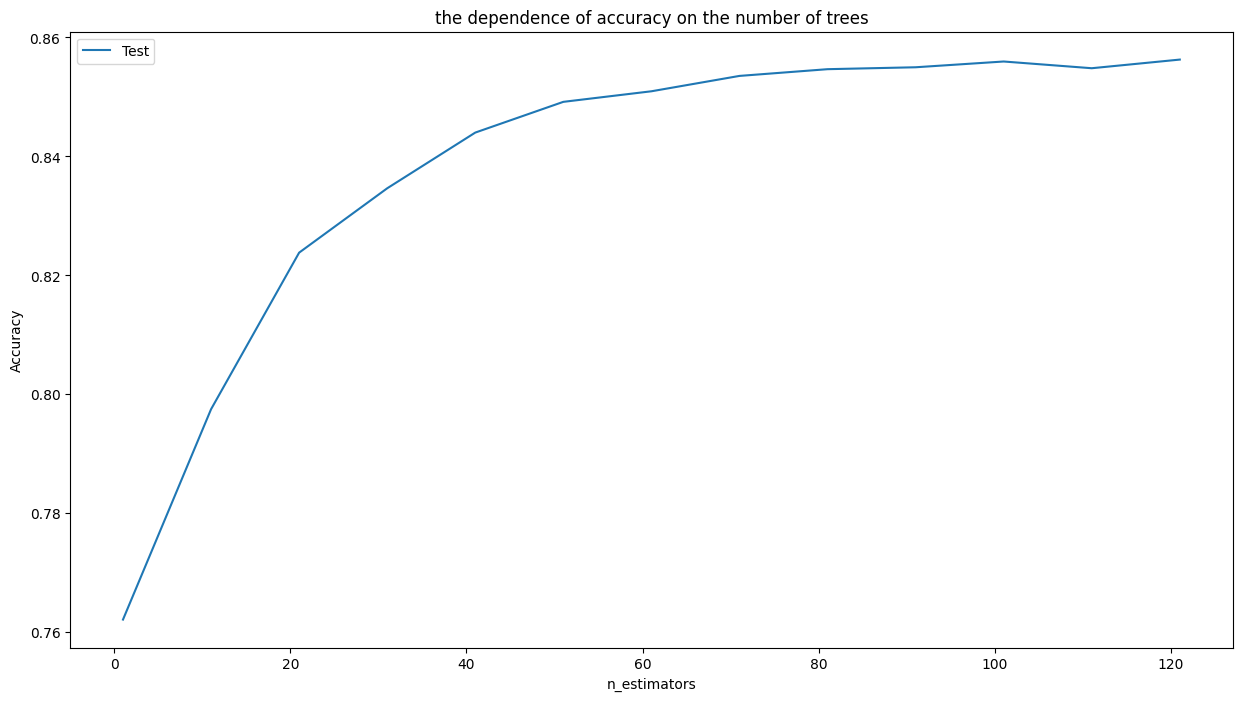

In [136]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 8))
plt.title("the dependence of accuracy on the number of trees")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.plot(trees_acc.keys(), trees_acc.values(), label='Test')
plt.legend()
plt.show()

In [137]:
trees_acc = {}
my_clf = MyGradientBoostingClassifier(loss="mse", n_estimators=100, max_depth=3)
my_clf.fit(X_train, y_train)

In [138]:
cumulative_pred = np.zeros(len(y_test))
accuracy_scores = {}
for i, trees in enumerate(my_clf.trees):
    step_pred = np.zeros(len(y_test))
    for tree, idx_features in trees:
        step_pred += my_clf.learning_rate * tree.predict(X_test[:, idx_features])
    cumulative_pred += step_pred
    # Если функция потерь предполагает использование softmax (для классификации)
    if my_clf.loss in ['log_loss', 'exp_loss']:
        final_pred = np.argmax(my_clf._softmax(cumulative_pred), axis=1)
    else:
        final_pred = np.round(cumulative_pred).astype(int)
    accuracy_scores[i+1] = accuracy_score(y_test, final_pred)

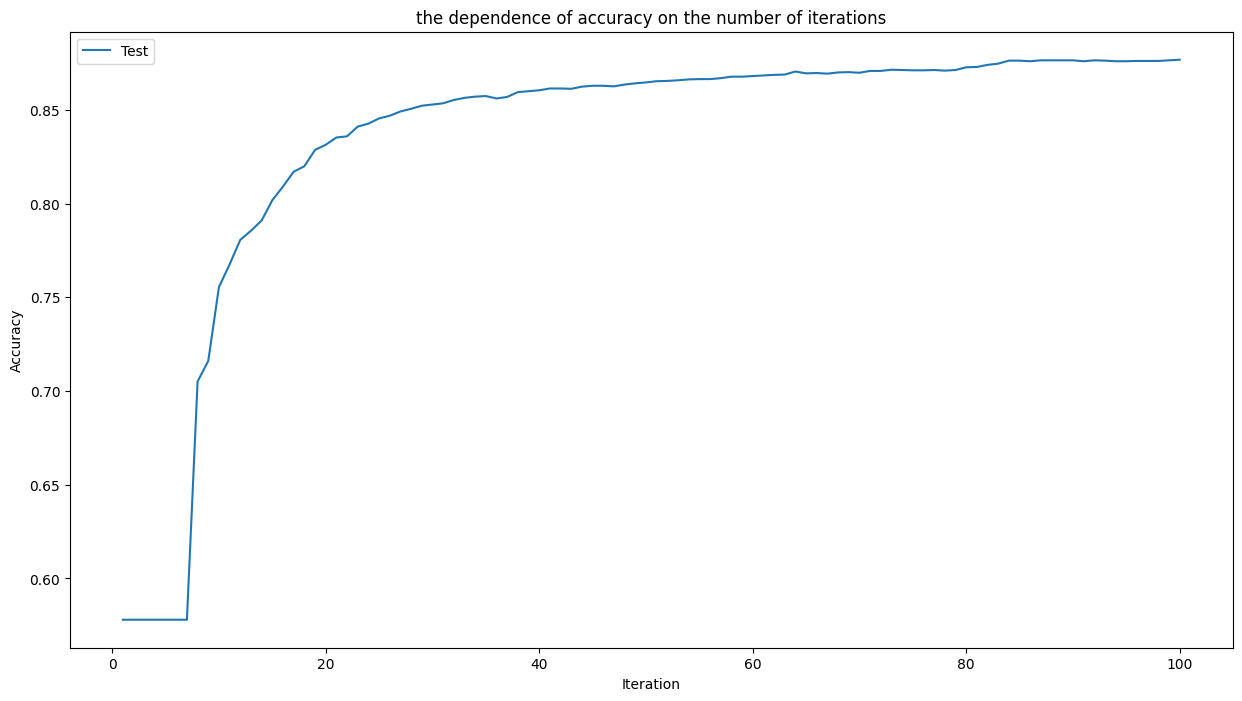

In [139]:
plt.figure(figsize=(15, 8))
plt.title("the dependence of accuracy on the number of iterations")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.plot(accuracy_scores.keys(), accuracy_scores.values(), label='Test')
plt.legend()
plt.show()

In [140]:
# !pip install optuna

GridSearch с нашей имплементацией бустинга не работает, потому что он не наследуется от sklearn'овского класса с определенными функциями. Будем применять optuna, это фреймворк, который с помощью математики эффективно подбирает гиперпараметры. О нем мне рассказали на семинаре на майноре ИАД в университете

In [141]:
import optuna

def objective(trial):
    # Определение гиперпараметров, подлежащих оптимизации
    loss = trial.suggest_categorical('loss', ['mse', 'log_loss', 'exp_loss'])
    learning_rate = trial.suggest_float('learning_rate', 0.001, 0.5)
    n_estimators = trial.suggest_int('n_estimators', 10, 150)
    colsample = trial.suggest_float('colsample', 0.5, 1.0)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    max_depth = trial.suggest_int("max_depth", 1, 10)

    # Создание модели с выбранными гиперпараметрами
    model = MyGradientBoostingClassifier(
        loss=loss,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        colsample=colsample,
        subsample=subsample,
        max_depth=max_depth
    )

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

# создание объекта study и запуск оптимизации
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=15)

# Получение лучших параметров
best_params = study.best_params
print("Best parameters found: ", best_params)


[I 2024-05-12 16:59:31,828] A new study created in memory with name: no-name-e3137e9a-5f69-4484-9832-d6d984becc80
[I 2024-05-12 16:59:40,453] Trial 0 finished with value: 0.8491602067183462 and parameters: {'loss': 'exp_loss', 'learning_rate': 0.028908808034220138, 'n_estimators': 89, 'colsample': 0.943722681800452, 'subsample': 0.7374497681386828, 'max_depth': 5}. Best is trial 0 with value: 0.8491602067183462.
[I 2024-05-12 16:59:41,757] Trial 1 finished with value: 0.8896963824289406 and parameters: {'loss': 'mse', 'learning_rate': 0.07696389687024911, 'n_estimators': 38, 'colsample': 0.5949792026187972, 'subsample': 0.6379746765050651, 'max_depth': 9}. Best is trial 1 with value: 0.8896963824289406.
[I 2024-05-12 16:59:48,915] Trial 2 finished with value: 0.8905038759689923 and parameters: {'loss': 'log_loss', 'learning_rate': 0.0862068830819447, 'n_estimators': 53, 'colsample': 0.744469845651284, 'subsample': 0.9827047828878371, 'max_depth': 9}. Best is trial 2 with value: 0.89050

Best parameters found:  {'loss': 'exp_loss', 'learning_rate': 0.11683118729220346, 'n_estimators': 109, 'colsample': 0.6523048566144806, 'subsample': 0.8312420234610918, 'max_depth': 7}


Лучший accuracy получился 0.8964793281653747 с параметрами выше

## BooBag BagBoo (1 балл)



Попробуем объединить бустинг и бэгинг. Давайте

1) в качестве базовой модели брать не дерево решений, а случайный лес (из sklearn)

2) обучать N бустингов на бустрапированной выборке, а затем предикт усреднять

Попробуйте обе этих стратегии на данных из прошлого задания. Получилось ли улучшить качество? Почему?

In [142]:
from sklearn.ensemble import RandomForestRegressor
# 3 минуты
my_clf = MyGradientBoostingClassifier(loss='exp_loss', learning_rate=0.41054047686577266, n_estimators=19, colsample=0.694336609786294, subsample=0.9881482307592161, max_depth=10)
my_clf.fit(X_train, y_train, base_model=RandomForestRegressor)
print(accuracy_score(y_test, my_clf.predict(X_test)))

0.8914728682170543


In [143]:
from sklearn.utils import resample

def train_boosting_baggings(X_train, y_train, X_test, y_test, n_estimators=10, n_boostings=5):
    predictions = []

    for i in range(n_boostings):
        # бутстрап
        X_boot, y_boot = resample(X_train, y_train)

        boosting = MyGradientBoostingClassifier(
            loss='exp_loss',
            learning_rate=0.41054047686577266,
            n_estimators=19,
            colsample=0.694336609786294,
            subsample=0.9881482307592161,
            max_depth=10
        )
        boosting.fit(X_boot, y_boot)

        # текущий бустинг
        pred = boosting.predict(X_test)
        predictions.append(pred)

    average_predictions = np.mean(predictions, axis=0)
    average_predictions = np.round(average_predictions).astype(int)


    accuracy = accuracy_score(y_test, average_predictions)
    return accuracy

train_boosting_baggings(X_train, y_train, X_test, y_test, n_boostings=10)

0.8864664082687338

Качество не улучшилось. Случайный лес дал почти такой же результат, как и обычный бустинг, возможно, если понастраивать, то качество чуть-чуть улучшится, но все равно вряд ли будет сильный эффект. Также возможно переобучение, модель становится слишком сложной. На бэггинге качество упало,

## Умная инициализация (1 балл)

Попробуйте брать в качестве инициализации бустинга не константу, а какой-то алгоритм и уже от его предикта стартовать итерации бустинга. Попробуйте разные модели из sklearn: линейные модели, рандом форест, svm..

Получилось ли улучшить качество? Почему?



In [144]:
from sklearn.linear_model import LogisticRegression, Lasso, Ridge
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
init_models = [LogisticRegression(max_iter=1000), Lasso(), Ridge(), SVC(probability=True),RandomForestClassifier(), RandomForestRegressor()]

In [145]:
for model in init_models:
    boosting_model = MyGradientBoostingClassifier(learning_rate=0.3, max_depth=3)
    boosting_model.fit(X_train, y_train, init_model=model)
    y_pred = boosting_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(model.__class__.__name__, accuracy)

LogisticRegression 0.8806524547803618
Lasso 0.8867894056847545
Ridge 0.8887273901808785
SVC 0.8843669250645995
RandomForestClassifier 0.8882428940568475
RandomForestRegressor 0.8796834625322998


In [146]:
boosting_model = MyGradientBoostingClassifier(learning_rate=0.3, max_depth=3)
boosting_model.fit(X_train, y_train)
y_pred = boosting_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.8856589147286822

Качество существенно не улучшилось, некоторые модели выдали чуть лучшее значение метрики, чем такой же бустинг без init_model. Если подобрать параметры, может быть получится что-то более хорошее. Это должно работать лучше, в особенности быстрее, так как бустинг стартует с уже каких-то предсказаний. Если данные линейно зависимы, то хорошо будут работать линейные модели. Случайные лес лучше работает, если у нас нелинейные зависимости. В нашем случае лучше сработал Ridge, то есть данные достаточно линейные.

## Фидбек (бесценно)

* Какие аспекты обучения  ансамблей Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

Как-то мало сказали про многоклассовую классификацию в этой домашке, тема довольно сложная для внедрения в бустинг, хотелось бы пояснений дополнительных.